# Lung scATAC analysis

#### We are providing a scATAC Seurat object with information on ACE2, TMPRSS2 and CTSL, and the code required to reproduce the plots in the manuscript (with the exception of motif analysis - see below). Should your COVID-19 research benefit form additional information, please do reach out to regev-office@broadinstitute.org


In [1]:
# The notebook below can be run in Custom Environment with "schaluvadi/cross_tissue_analysis:v1.6" as Container image
# The Docker Container image includes all the packages required to run this notebook

In [2]:
# The original analysis was run with the R version, package version below
# However, most of them are not required to run this notebook  

# R version 3.6.0

# Seurat_3.1.1
# Signac_0.1.6
# GenomeInfoDb_1.22.0
# ggplot2_3.3.0
# chromVAR_1.6.0
# motifmatchr_1.6.0
# JASPAR2020_0.99.8
# TFBSTools_1.25.1
# EnsDb.Hsapiens.v86_2.99.0
# BSgenome.Hsapiens.UCSC.hg38_1.4.1
# ComplexHeatmap_2.0.0
# RColorBrewer_1.1-2
# rtracklayer_1.46.0
# dplyr_0.8.4
# repr_1.0.1
# gridExtra_2.3


In [3]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(ggplot2)
library(ComplexHeatmap)
library(chromVAR)
library(motifmatchr)
library(RColorBrewer)
library(rtracklayer)
library(dplyr)
library(repr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(EnsDb.Hsapiens.v86)
library(gridExtra)

set.seed(1234)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The

In [4]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gridExtra_2.3                     EnsDb.Hsapiens.v86_2.99.0        
 [3] ensembldb_2.8.1                   AnnotationFilter_1.8.0           
 [5] GenomicFeatures_1.36.4            AnnotationDbi_1.46.1             
 [7] Biobase_

In [5]:
## Loading raw data
## QC
## Processing

In [1]:
system('gsutil cp gs://fc-1a9c7c2a-7fd9-4a7a-9e43-8f3d3cfee66d/20200327_lungATAC_onlyACE2_TMPRSS2_CTLS.rds .')

In [2]:
## Loading processed data 
lung=readRDS('20200327_lungATAC_onlyACE2_TMPRSS2_CTLS.rds')

In [3]:
lung

Loading required package: Seurat



An object of class Seurat 
3 features across 11706 samples within 1 assay 
Active assay: RNA (3 features)
 1 dimensional reduction calculated: umap

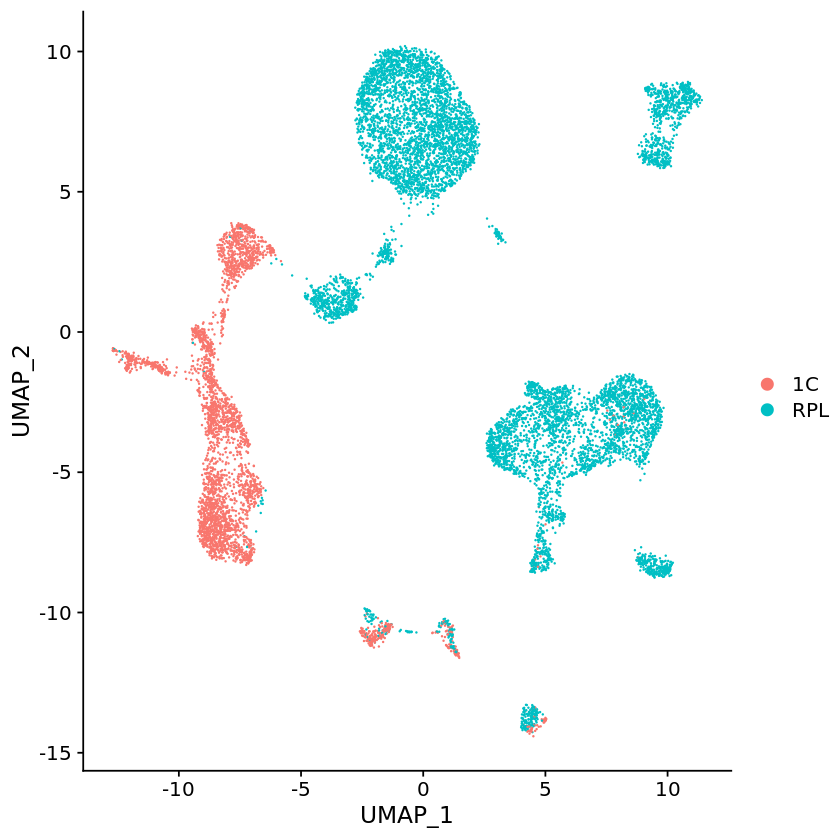

In [9]:
DimPlot(object = lung, group.by= 'location', pt.size=.05)

In [10]:
table(lung@meta.data$location)


  1C  RPL 
3366 8340 

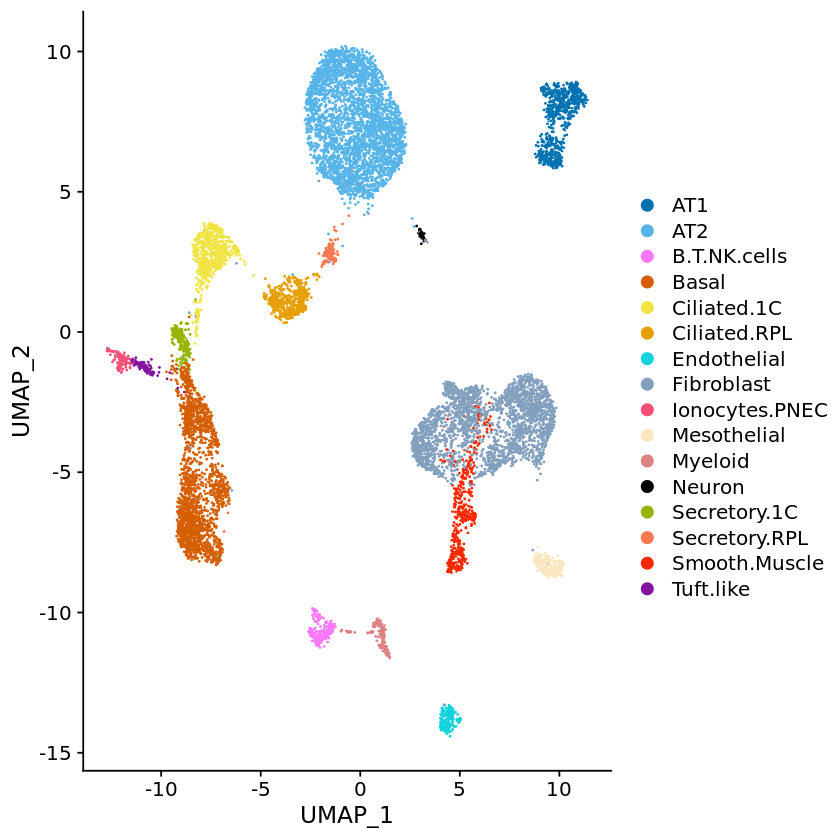

In [11]:
DimPlot(lung, group.by = 'revised.annot_2', label = F,cols = c("AT1" = "#0072B2", 
"AT2" = "#56B4E9",  
"B.cells" = "#009E73",  
"Basal" = "#D55E00",  
"Ciliated.RPL" = "#E69F00",  
"Ciliated.1C" = "#F0E442",  
"Endothelial" = "#14D2DC",  
"Fibroblast" = "#82A0BE",  
"Ionocytes.PNEC" = "#FA5078", 
"Myeloid" = "#DC8282",  
"Mesothelial" = "#FAE6BE",  
"Neuron" = 'black',                                                                
"Secretory.RPL" = "#FA7850", 
"Secretory.1C" = "#96B400",  
"Smooth.Muscle" = "#FA2800",  
"B.T.NK.cells" = "#FA78FA",  
"Tuft.like" ="#8214A0"))

In [12]:
table(lung@meta.data$revised.annot_2)


           AT1            AT2   B.T.NK.cells          Basal    Ciliated.1C 
           730           3371            227           1962            644 
  Ciliated.RPL    Endothelial     Fibroblast Ionocytes.PNEC    Mesothelial 
           484            188           2579            135            252 
       Myeloid         Neuron   Secretory.1C  Secretory.RPL  Smooth.Muscle 
           174             46            200            119            474 
     Tuft.like 
           121 

### Gene 'activity' of genes of interest

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



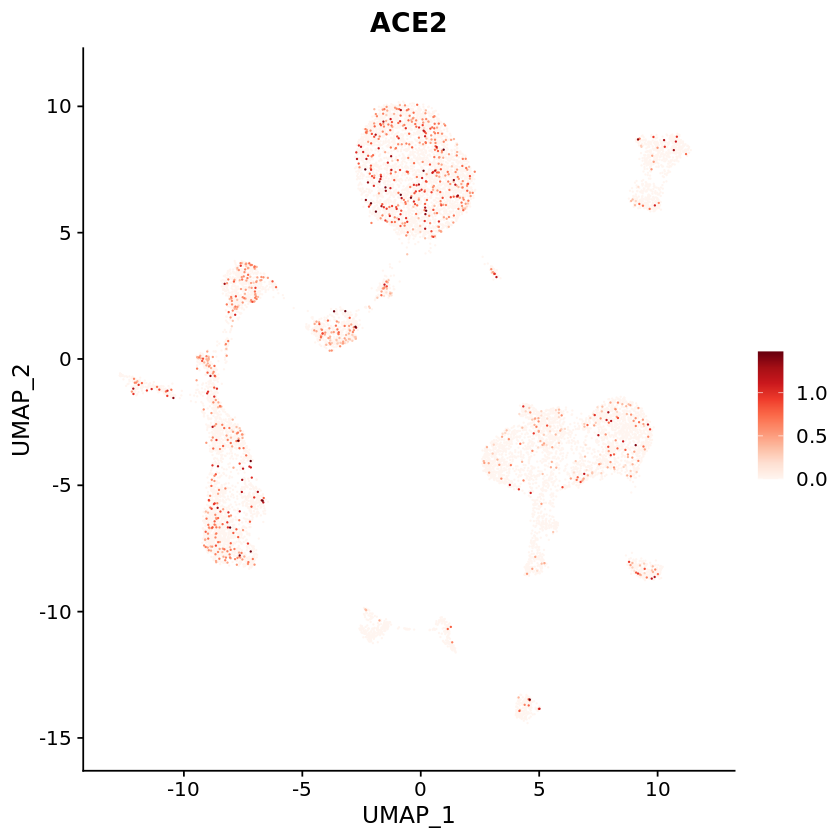

In [13]:
DefaultAssay(lung) <- 'RNA'
FeaturePlot(
  object = lung,
  features = 'ACE2',
  pt.size = 0.02,
  max.cutoff = 'q99',
  ncol = 3, 
  order=T
) + scale_color_gradientn(colors = brewer.pal(9, "Reds"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



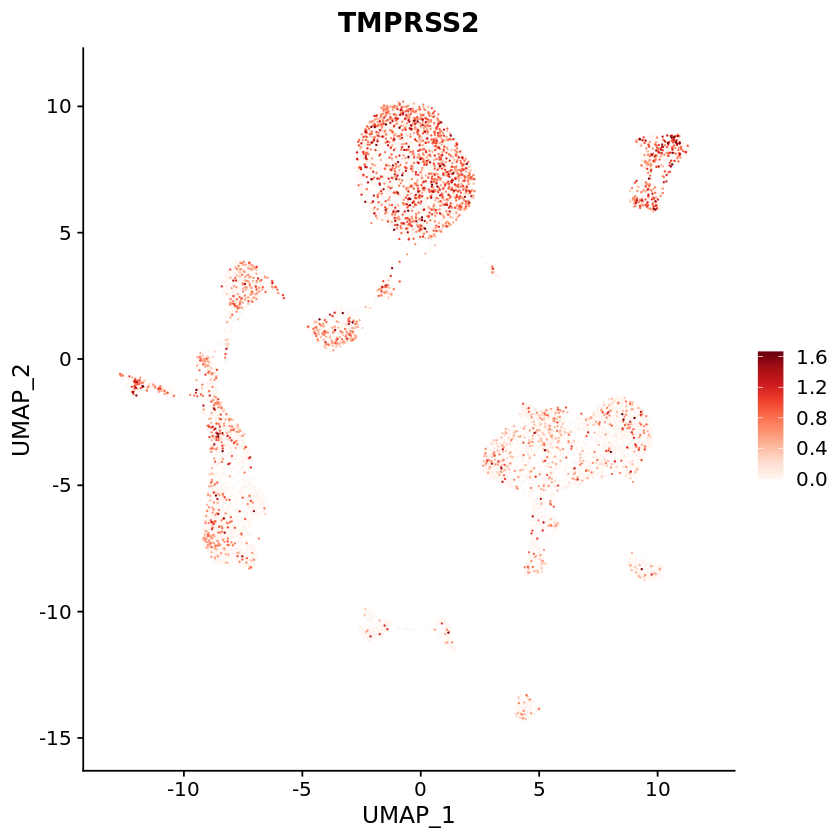

In [14]:
FeaturePlot(
  object = lung,
  features = 'TMPRSS2',
  pt.size = 0.02,
  max.cutoff = 'q99',
  ncol = 3, 
  order=T
) + scale_color_gradientn(colors = brewer.pal(9, "Reds"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



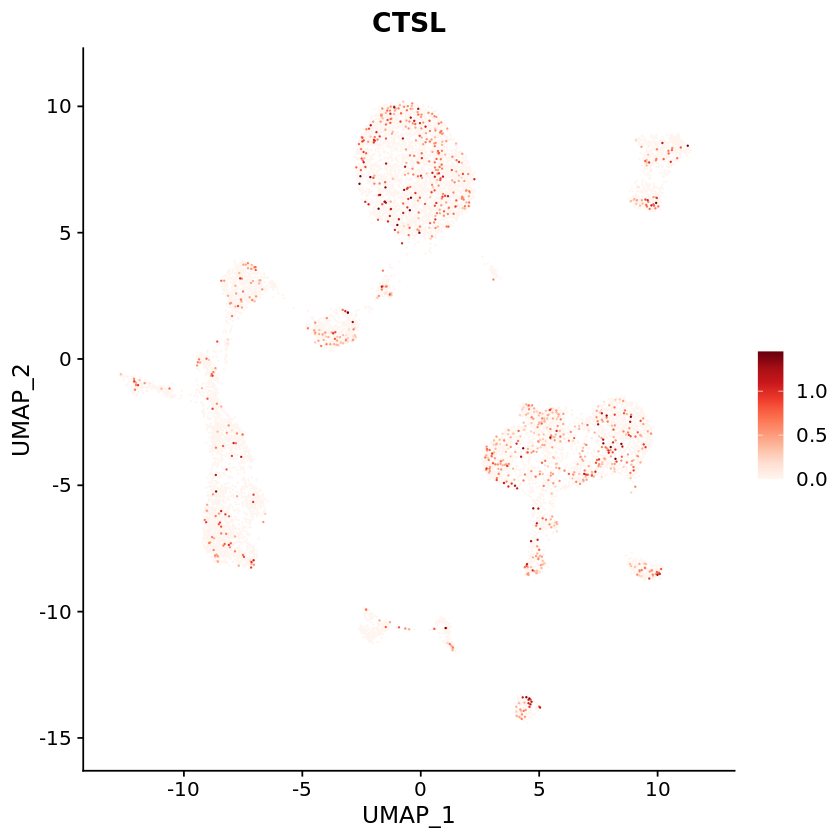

In [15]:
FeaturePlot(
  object = lung,
  features = 'CTSL',
  pt.size = 0.02,
  max.cutoff = 'q99',
  ncol = 3, 
  order=T
) + scale_color_gradientn(colors = brewer.pal(9, "Reds"))

### Select ACE2 and TMPRSS2 positive cells

In [16]:
gene_of_int='ACE2'
gene_of_int2='TMPRSS2'
exp_thresh = 1

flt_pt1 = lung[['RNA']]@counts[gene_of_int,] >= exp_thresh
flt_pt2 = flt_pt1 & (lung[['RNA']]@counts[gene_of_int2,] >= exp_thresh) 

lung@meta.data$ACE2_moreeq1 = 'other'
lung@meta.data$ACE2_moreeq1[flt_pt1] = 'ACE2_more_eq1count'


lung@meta.data$ACE2_TMPRSS2_moreeq1 = 'other'
lung@meta.data$ACE2_TMPRSS2_moreeq1[flt_pt2] = 'ACE2_TMPRSS2_more_eq1count'


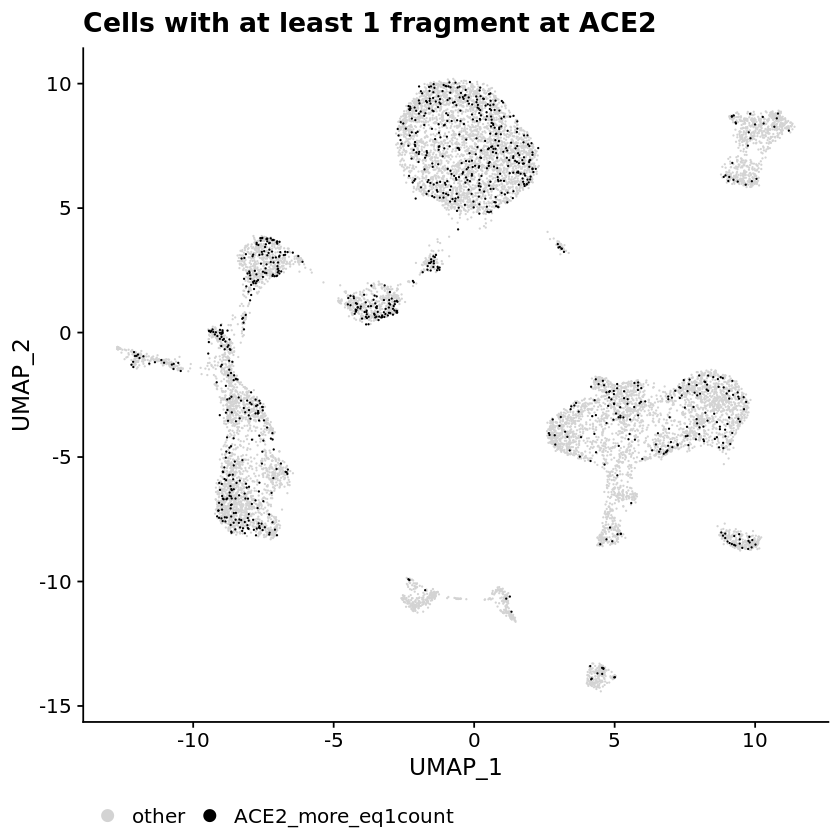

In [17]:
DimPlot(lung, group.by = 'ACE2_moreeq1', order='ACE2_more_eq1count', cols=c('other' = 'lightgrey', 
                                                           'ACE2_more_eq1count' = 'black'),  
        pt.size = 0.000001,
) +ggtitle('Cells with at least 1 fragment at ACE2') + theme(legend.position="bottom")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



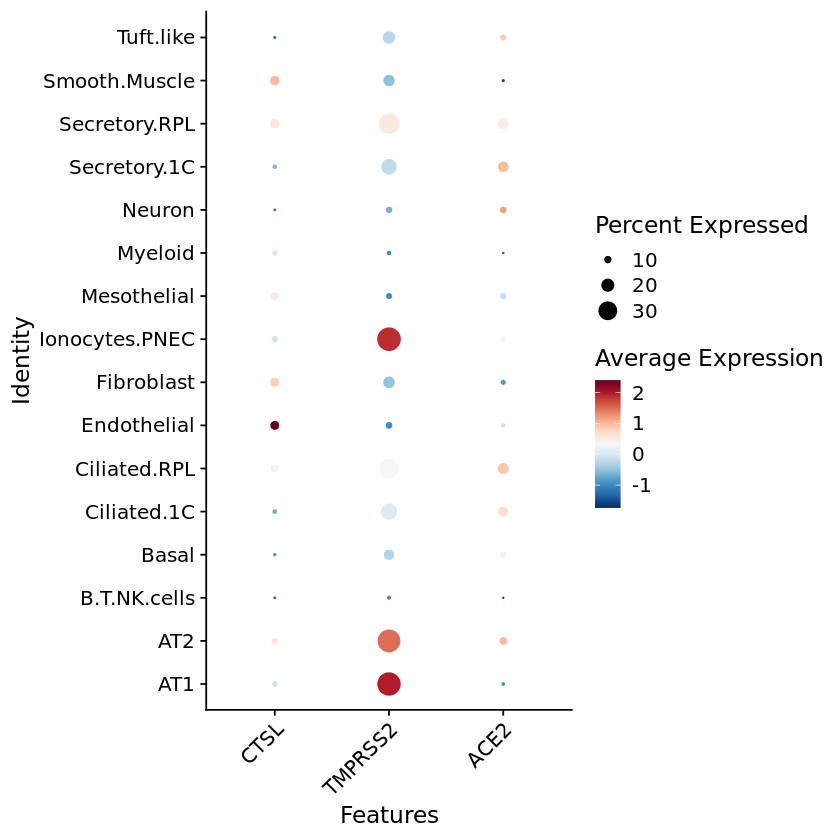

In [18]:
DotPlot(lung, group.by = 'revised.annot_2',  features = c('ACE2', 'TMPRSS2', 'CTSL')) + RotatedAxis() + scale_color_gradientn(colors = rev(brewer.pal(11, "RdBu")))

In [19]:
dp=subset(lung@meta.data, select=c('revised.annot_2', 'ACE2_TMPRSS2_moreeq1'))

In [20]:
tab_dp=as.data.frame.matrix(table(dp$revised.annot_2, dp$ACE2_TMPRSS2_moreeq1))

tab_dp$percent=round((tab_dp$ACE2_TMPRSS2_more_eq1count/(tab_dp$ACE2_TMPRSS2_more_eq1count + tab_dp$other))*100, digits = 2)

head(tab_dp)

,ACE2_TMPRSS2_more_eq1count,other,percent
,<int>,<int>,<dbl>
AT1,9,721,1.23
AT2,168,3203,4.98
B.T.NK.cells,2,225,0.88
Basal,30,1932,1.53
Ciliated.1C,31,613,4.81
Ciliated.RPL,32,452,6.61


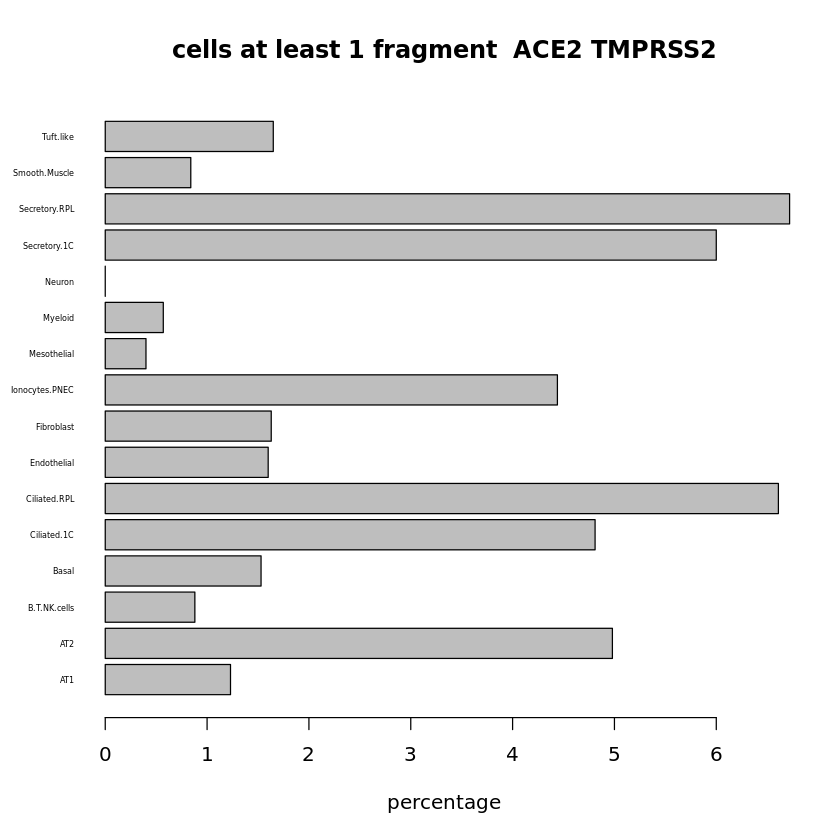

In [21]:
barplot(tab_dp$percent, names=rownames(tab_dp), horiz = T, las = 1, cex.names=0.4, xlab='percentage', main='cells at least 1 fragment  ACE2 TMPRSS2')

### Select ACE2 'positive' epithelial cells

In [22]:
gene_of_int='ACE2'
exp_thresh = 1

flt_pt1 = lung@meta.data$revised.annot_2 %in% c('AT1','AT2', 'Basal', 'Ciliated.1C', 'Ciliated.RPL', 'Ionocytes.PNEC', 'Secretory.1C', 'Secretory.RPL', 'Tuft.like')
flt_pt2 = flt_pt1 & (lung[['RNA']]@counts[gene_of_int,] >= exp_thresh) 

flt_pt3 = flt_pt1 & (lung[['RNA']]@counts[gene_of_int,] < exp_thresh)

lung@meta.data$epith_group = 'other_cells'
lung@meta.data$epith_group[flt_pt1] = 'Epith_other'
lung@meta.data$epith_group[flt_pt2] = 'Epith_ACE2_more_eq1'
lung@meta.data$epith_group[flt_pt3] = 'Epith_ACE2_neg'


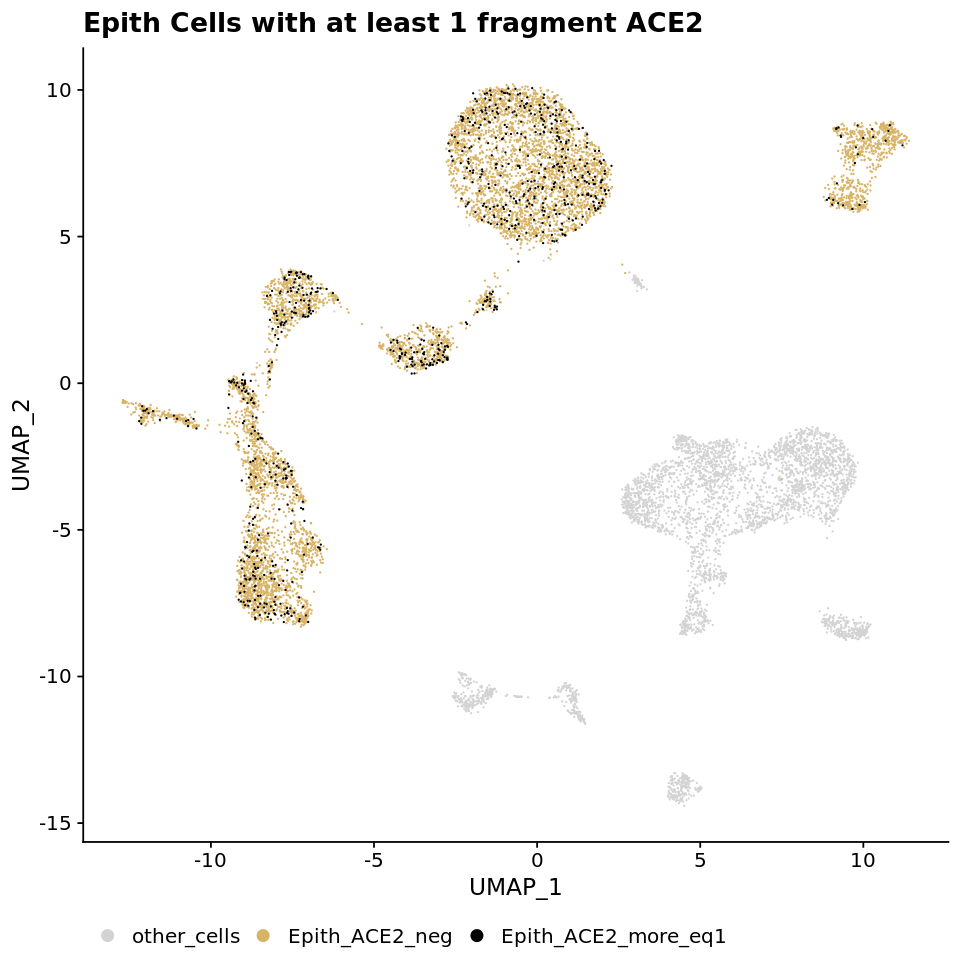

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(lung, group.by = 'epith_group', order='Epith_ACE2_more_eq1', 
        cols=c('other_cells' = 'lightgrey', 
               'Epith_ACE2_neg' = '#d8b365', 
               'Epith_other' = '#5ab4ac', 
               'Epith_ACE2_more_eq1' = 'black'),  
        pt.size = 0.000001,
) +ggtitle('Epith Cells with at least 1 fragment ACE2') + theme(legend.position="bottom")

### ChromVAR 'markers' 

In [21]:
### Code in this cell will not run because the object provided lacks ChromVar Assay - please get it touch if interested

DefaultAssay(lung) <- 'chromvar'

epi_ace2_p_marker_motif<- FindMarkers(
  object = lung,
  group.by='epith_group',
  ident.1 = 'Epith_ACE2_more_eq1',
  ident.2 = 'Epith_ACE2_neg',
  only.pos = TRUE,
  test.use = 'LR',
  latent.vars = 'nCount_peaks', 
)
subset(epi_ace2_p_marker_motif, p_val_adj <1)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRF1_MA0050.1,2.457011e-05,0.5829078,0.360,0.292,0.01990179
IRF7_MA0772.1,9.501319e-05,0.3977183,0.306,0.249,0.07696068
STAT1::STAT2_MA0517.1,1.949853e-04,0.6069283,0.335,0.276,0.15793811
FOXA1_MA0148.2,2.909351e-04,0.9415472,0.829,0.775,0.23565744
FOXD2_MA0847.2,3.292566e-04,1.8421963,0.801,0.744,0.26669781
CDX2_MA0465.2,3.490678e-04,0.3039219,0.418,0.359,0.28274493
FOXA1_MA0148.1,3.820777e-04,0.8484952,0.831,0.774,0.30948297
IRF2_MA0051.1,4.107653e-04,0.6469624,0.375,0.324,0.33271987
FOXC1_MA0032.2,4.515934e-04,1.2623710,0.754,0.687,0.36579061


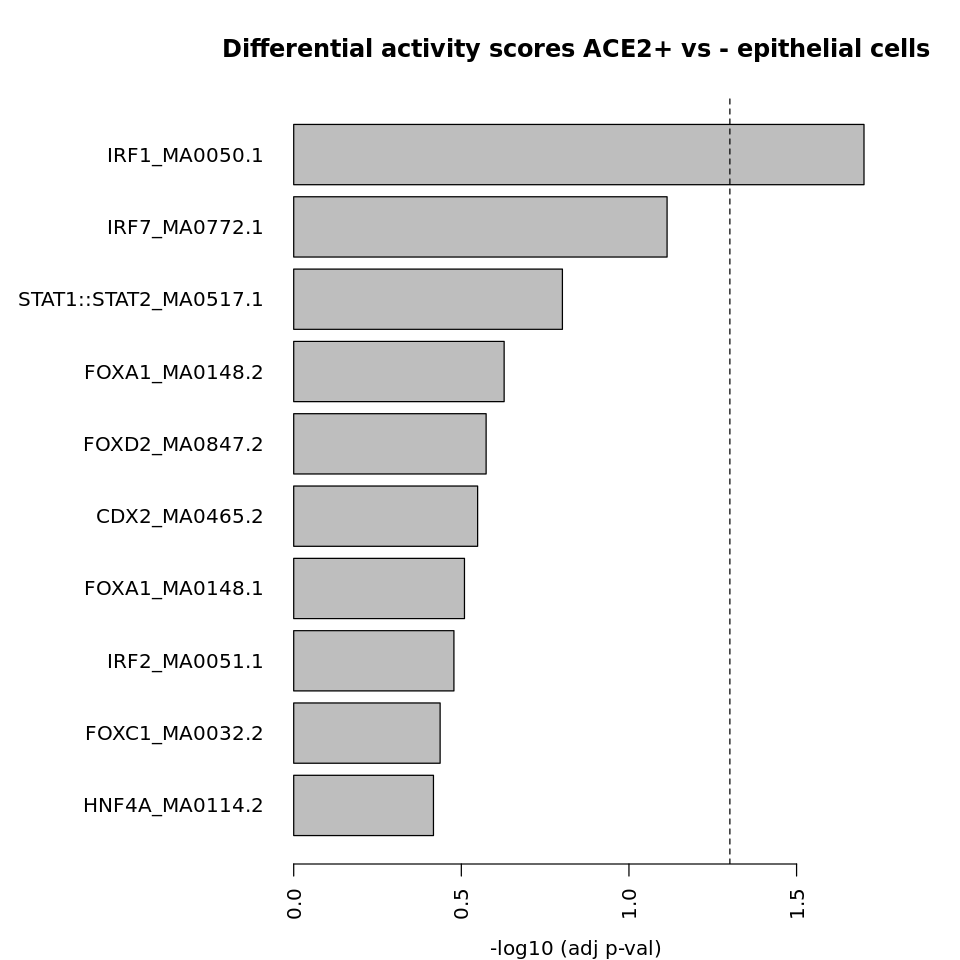

In [22]:
### Code in this cell will not run because the object provided lacks ChromVar Assay so the cell above could not run - please get it touch if interested

t10=head(epi_ace2_p_marker_motif, n=10)

t10b  <- t10[order(t10[,1], decreasing=TRUE),]

par(mar=c(4,12,4,4))
barplot(-log10(t10b$p_val_adj ), horiz = T, names.arg = rownames(t10b), las=2, main = 'Differential activity scores ACE2+ vs - epithelial cells', xlab='-log10 (adj p-val)', col="grey" )
abline(v=(-log10(0.05)), lty=2)

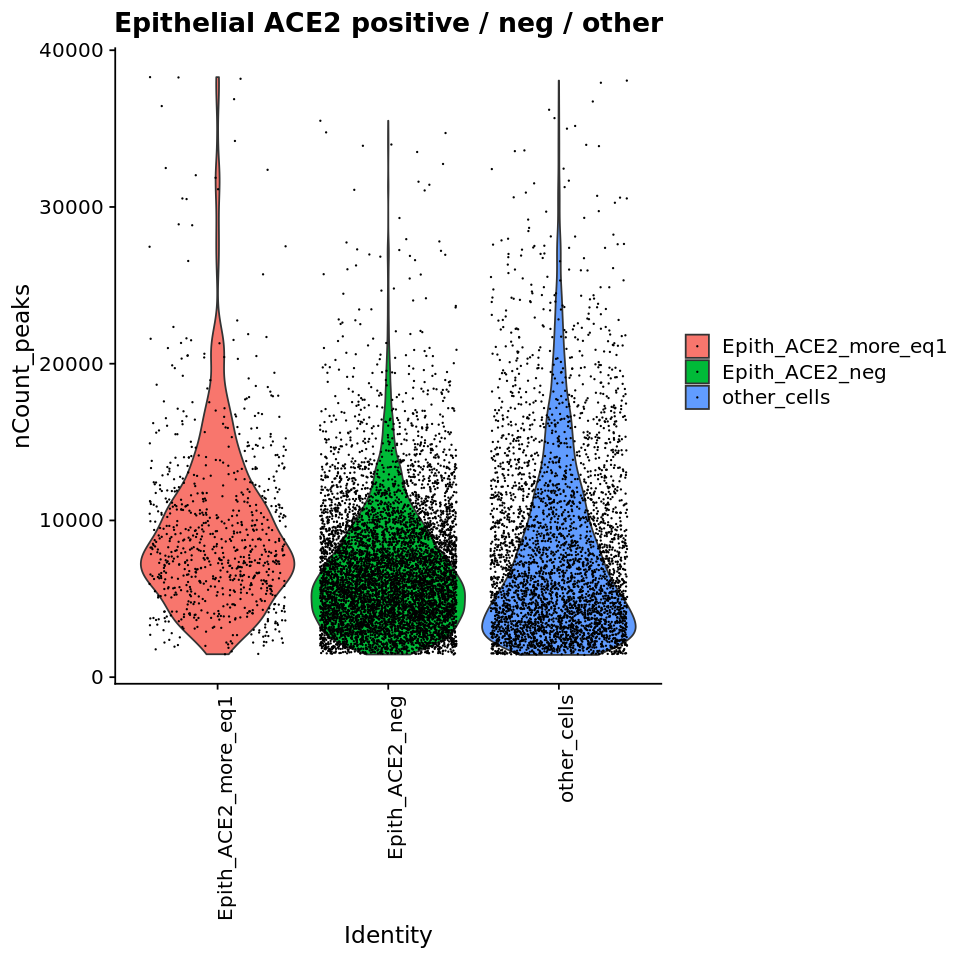

In [24]:
VlnPlot(lung, features = c("nCount_peaks"), group.by = 'epith_group', pt.size = .01)+ theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ylab('nCount_peaks') + ggtitle('Epithelial ACE2 positive / neg / other')
